## Phase contrast tomography

In this tutorial notebook, we will reconstruct the electrostatic potential of a simulated carbon nanotube sample using multiple tilt measurements.

### Downloads
* [CNT 5D-STEM dataset](https://drive.google.com/file/)

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Georgios Varnavides (gvarnavides@berkeley.edu)
- Stephanie Ribet (sribet@u.northwestern.edu)
- Colin Ophus (clophus@lbl.gov)

The 5D-STEM dataset used here was simulated in abTEM using the following parameters:
- Tilt angles: -90 to 90, in steps of 6 degrees
- Convergence angle: 25 mrad
- Accelerating voltage: 80 kV
- Probe aberrations: 150 A defocus
- Poisson noise: 10,000 e/A$^2$

_Note:_ The following reconstructions are quite expensive. The dimensions were chosen such that they _just_ about fit in a GPU with 24GB of VRAM to ensure reasonable speeds.

Tutorial Updated 2023 Mar 31

In [1]:
import numpy as np
import h5py
import py4DSTEM
py4DSTEM.__version__

'0.13.17'

# Load data, basic visualization

First, we load the dataset and plot the mean diffraction pattern:

In [2]:
file_path = 'data/'

In [3]:
reciprocal_space_sampling = 2.4830142447596724
real_space_sampling = 0.6189636499827756
dcs = []

with h5py.File(file_path+"double_walled_cnt_m90-p90_6deg.h5", 'r') as f:
    data=f['data']
    
    for tilt_index in range(data.shape[0]):
        datacube = py4DSTEM.io.DataCube(data[tilt_index][:])
        datacube.calibration.set_R_pixel_size(real_space_sampling)
        datacube.calibration.set_R_pixel_units('A')
        datacube.calibration.set_Q_pixel_size(reciprocal_space_sampling)
        datacube.calibration.set_Q_pixel_units('mrad')
        dcs.append(datacube)

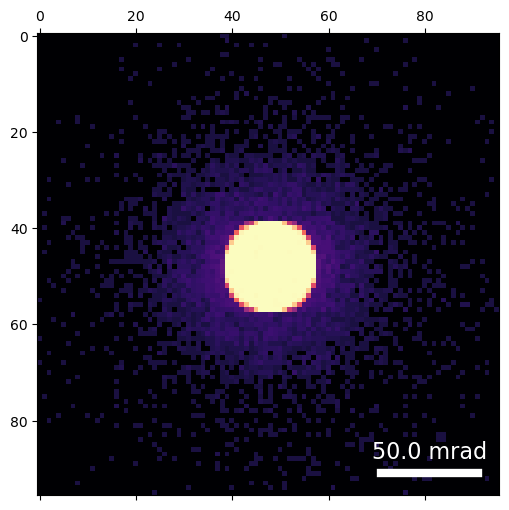

In [4]:
dcs[0].get_dp_mean()
py4DSTEM.show(
    dcs[0].tree["dp_mean"],
    cmap='magma',
    power=0.25,
    figsize=(6,6),
)

## Single-Tilt Single-Slice Reconstruction

First, let's see how well single-slice ptychography fares for a single tilt

/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:537: UserWarning: Best fit rotation forced to 0 degrees.
  warnings.warn(
/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:551: UserWarning: Transpose of intensities forced to False.
  warnings.warn(


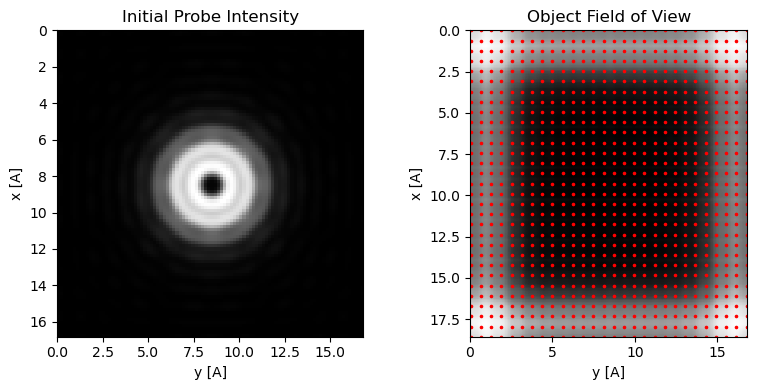

In [5]:
ptycho = py4DSTEM.process.phase.PtychographicReconstruction(
    dcs[15],# zero-tilt dataset
    verbose=True,
    energy=80e3,
    semiangle_cutoff=25,
    defocus=150,
    device='gpu',
    object_padding_px=(0,0),
).preprocess(
    force_com_rotation=0,
    force_com_transpose=False,
    plot_rotation=False,
    plot_center_of_mass = False,
)

Performing 8 iterations using the gradient-descent algorithm, with normalization_min: 0.001.


Reconstructing object and probe: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 19.94 iter/s]


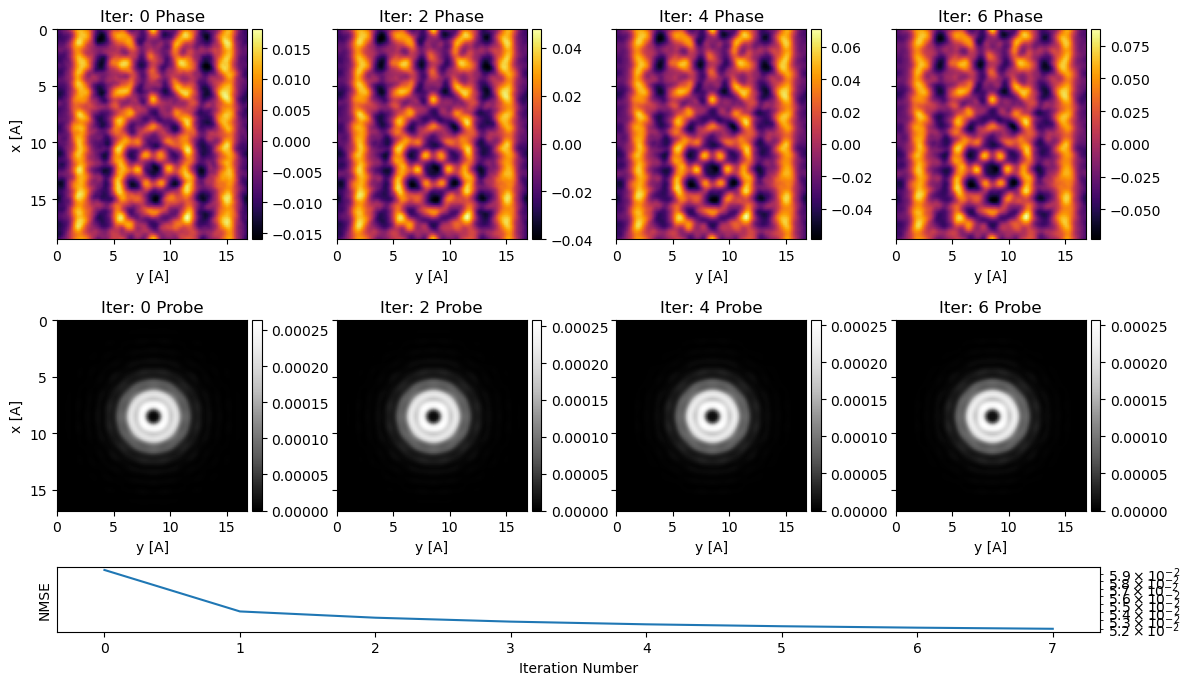

In [6]:
ptycho = ptycho.reconstruct(
    max_iter = 8,
    step_size=0.25,
    reset=True,
    store_iterations=True,
    normalization_min=0.001,
    q_lowpass=3.5,
).visualize(
    iterations_grid='auto',
)

Indeed, we can see the two nested carbon nanotubes reconstructing quite nicely!

## Single-Tilt Multi-Slice Reconstruction

This is using the single-slice approximation, and while this is fairly reasonable for a such a thin, weakly scattering object - we can start getting depth information using the multi-slice formalism.

/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:537: UserWarning: Best fit rotation forced to 0 degrees.
  warnings.warn(
/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:551: UserWarning: Transpose of intensities forced to False.
  warnings.warn(


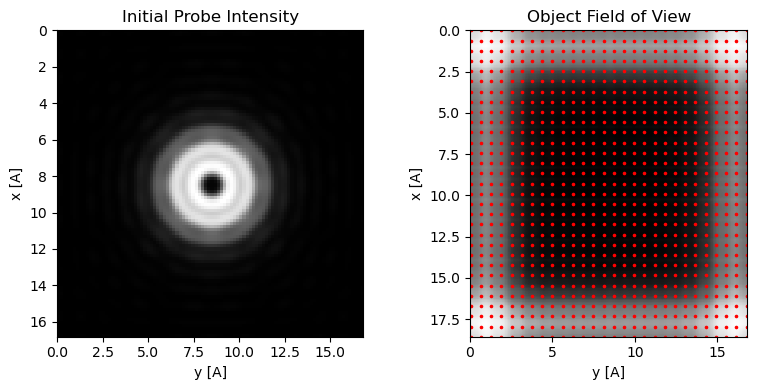

In [7]:
ms_ptycho = py4DSTEM.process.phase.MultislicePtychographicReconstruction(
    dcs[15],# zero-tilt dataset
    verbose=True,
    energy=80e3,
    num_slices=6,
    slice_thicknesses=3.0,
    semiangle_cutoff=25,
    defocus=150,
    device='gpu',
    object_padding_px=(0,0),
).preprocess(
    force_com_rotation=0,
    force_com_transpose=False,
    plot_rotation=False,
    plot_center_of_mass = False,
)

Performing 8 iterations using the gradient-descent algorithm, with normalization_min: 0.001.


Reconstructing object and probe: 100%|███████████████████████████████████| 8/8 [00:01<00:00,  4.94 iter/s]


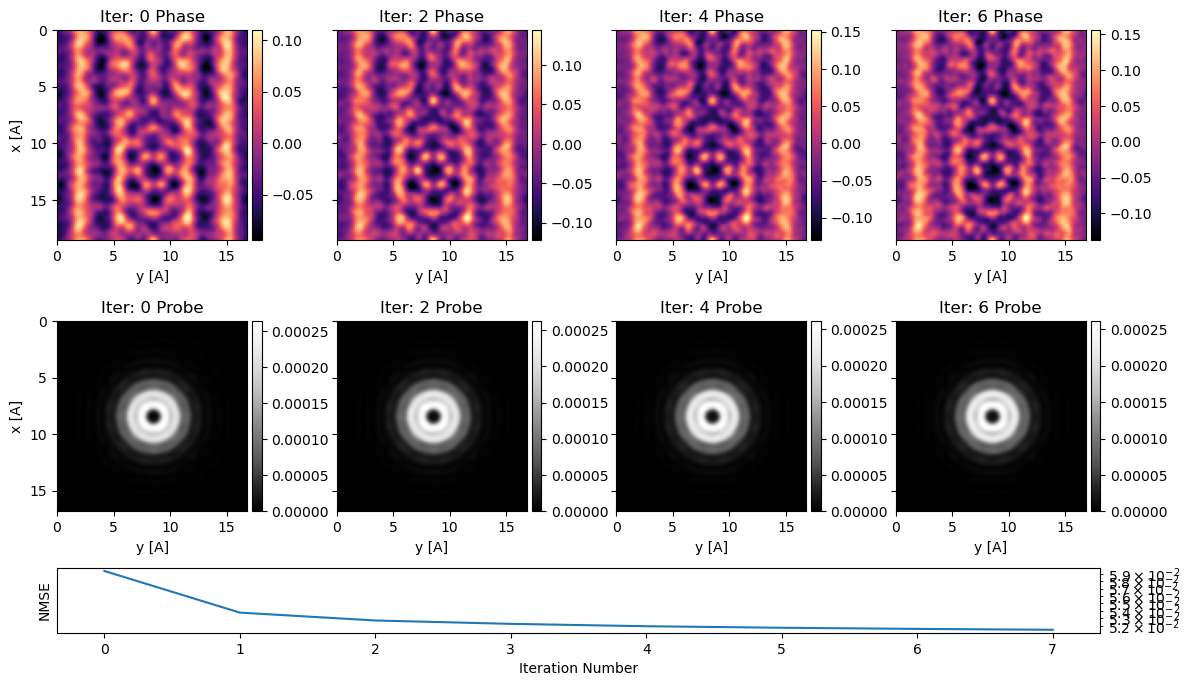

In [8]:
ms_ptycho = ms_ptycho.reconstruct(
    max_iter = 8,
    step_size=0.25,
    reset=True,
    store_iterations=True,
    normalization_min=0.001,
    q_lowpass=3.5,
).visualize(
    iterations_grid='auto',
)

This is already much crisper and will allows us to extend to 3D information.

## [Optional] "Standard" Tomography using 2D Ptychography Phase Images

The first thing to try is a "serial" approach, where we reconstruct 2D images for all the tilt projections and use a tomographic algorithm to reconstruct a 3D volume.

We collect our 30 ptychographic reconstructions in a 3D sinogram array

In [9]:
ptycho_sinogram = np.zeros((len(dcs),)+ptycho.object.shape)

for tilt_index in py4DSTEM.tqdmnd(len(dcs)):
    ms_ptycho = py4DSTEM.process.phase.MultislicePtychographicReconstruction(
        dcs[tilt_index],
        verbose=False,
        energy=80e3,
        num_slices=6,
        slice_thicknesses=3.0,
        semiangle_cutoff=25,
        defocus=150,
        device='gpu',
        object_padding_px=(0,0),
    ).preprocess(
        force_com_rotation=0,
        force_com_transpose=False,
        plot_center_of_mass = False,
        plot_probe_overlaps=False,
    ).reconstruct(
        progress_bar=False,
        max_iter = 8,
        step_size=0.25,
        reset=True,
        store_iterations=False,
        normalization_min=0.001,
        q_lowpass=3.5,
    )
    
    ptycho_sinogram[tilt_index]= np.angle(ms_ptycho.object).sum(0)

100%|█████████████████████████████████████████████████████████████████████| 30/30 [01:10<00:00,  2.34s/it]


And then use the `tomopy` package to reconstruct the 3D volume using the SIRT algorithm:

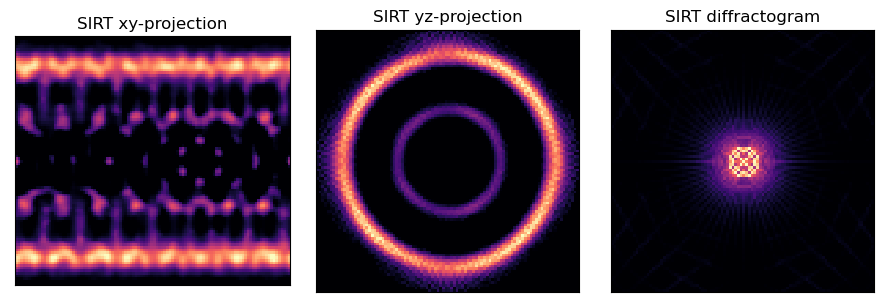

In [10]:
import tomopy

angles_rad=np.linspace(np.deg2rad(-90),np.deg2rad(90),31)[:-1]
tomopy_recon = tomopy.recon(ptycho_sinogram.clip(0), angles_rad, algorithm='sirt',num_iter=10)
tomopy_recon = tomopy.circ_mask(tomopy_recon, axis=0)

diffractogram_tomopy = np.fft.fftshift(
        np.abs(np.fft.fftn(tomopy_recon))
    )

py4DSTEM.show(
    [
        tomopy_recon.sum(1).T,
        tomopy_recon.sum(0),
        diffractogram_tomopy.sum(0)
    ],
    vmin=0.333,
    vmax=0.999,
    cmap='magma',
    ticks=False,
    title=["SIRT xy-projection", "SIRT yz-projection", "SIRT diffractogram"],
    axsize=(3,3),
)

## Overlap Tomography

Finally, let's try a "joint" reconstruction, where we attempt to reconstruct the 3D potential directly from a tilt-series of 4D-STEM measurements

Preprocessing data: 100%|███████████████████████████████████████████████| 30/30 [00:22<00:00,  1.35tilt/s]


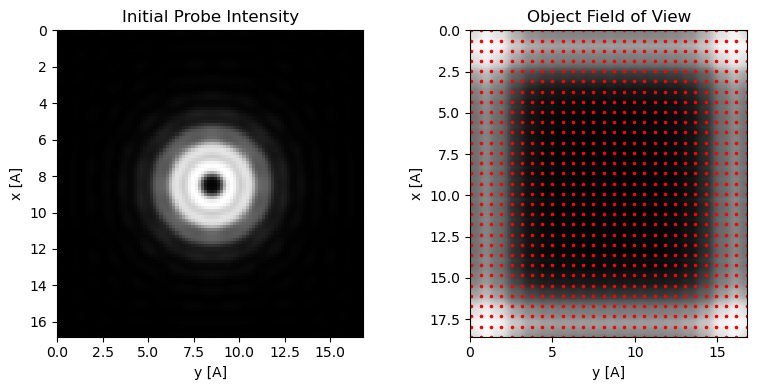

In [11]:
overlap_tomo = py4DSTEM.process.phase.OverlapTomographicReconstruction(
    dcs,
    verbose=True,
    energy=80e3,
    num_slices=24,
    tilt_angles_degrees = np.linspace(-90,90,31)[:-1],
    semiangle_cutoff=25,
    defocus=150,
    device='gpu',
    object_padding_px=(0,0),
).preprocess(
    plot_probe_overlaps=True,
    diffraction_patterns_rotate_degrees=0,
    diffraction_patterns_transpose=False
)

Performing 8 iterations using the gradient-descent algorithm, with normalization_min: 0.001.


Reconstructing object and probe: 100%|███████████████████████████████████| 8/8 [02:53<00:00, 21.67s/ iter]


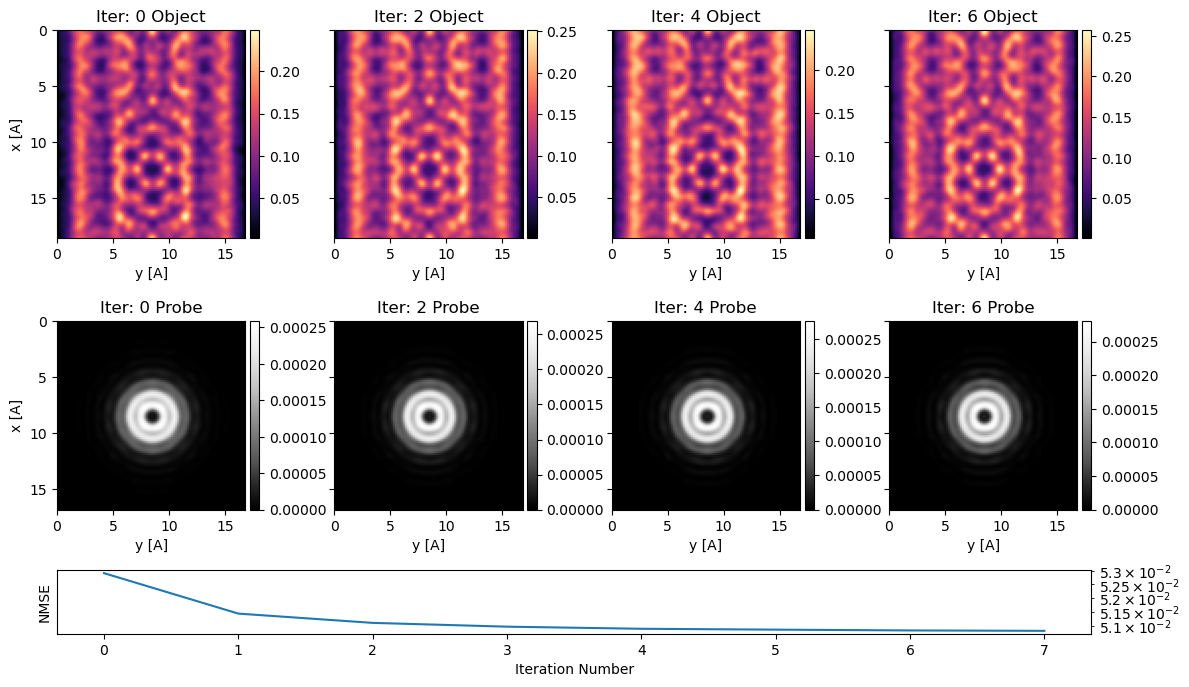

In [12]:
overlap_tomo = overlap_tomo.reconstruct(
    max_iter = 8,
    step_size=0.075,
    normalization_min=0.001,
    reset=True,
    store_iterations=True,
    q_lowpass=3.5,
).visualize(
    iterations_grid='auto',
    #projection_angle_deg=-90,
    #projection_axes=(0,1)
)

overlap_tomo_sequential = overlap_tomo.object

This looks quite good! Notice we can also plot the 3D volume along different projections - e.g. along the tilt axis:

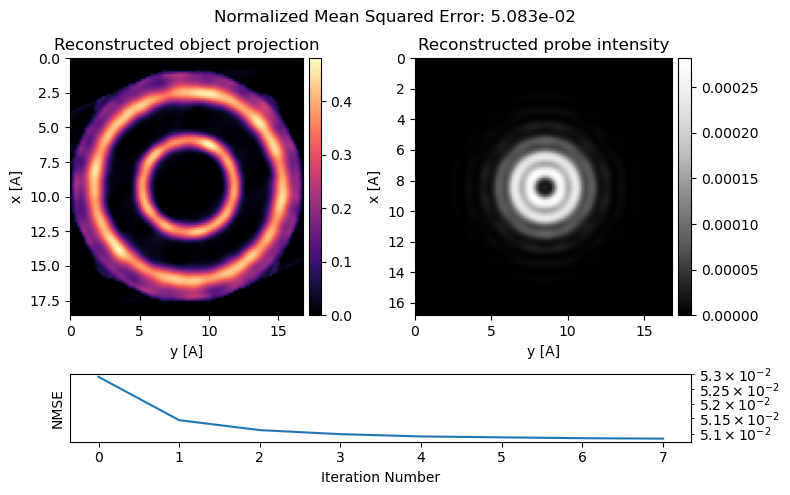

In [13]:
overlap_tomo.visualize(
    projection_angle_deg=-90,
    projection_axes=(0,1)
);

Our dataset was quite noisy, and thus the sequential projections can be unstable. We can instead use `collective_tilt_updates=True` to update the object using pooled updates from all tilts:

Performing 8 iterations using the gradient-descent algorithm, with normalization_min: 0.001.


Reconstructing object and probe: 100%|███████████████████████████████████| 8/8 [02:46<00:00, 20.85s/ iter]


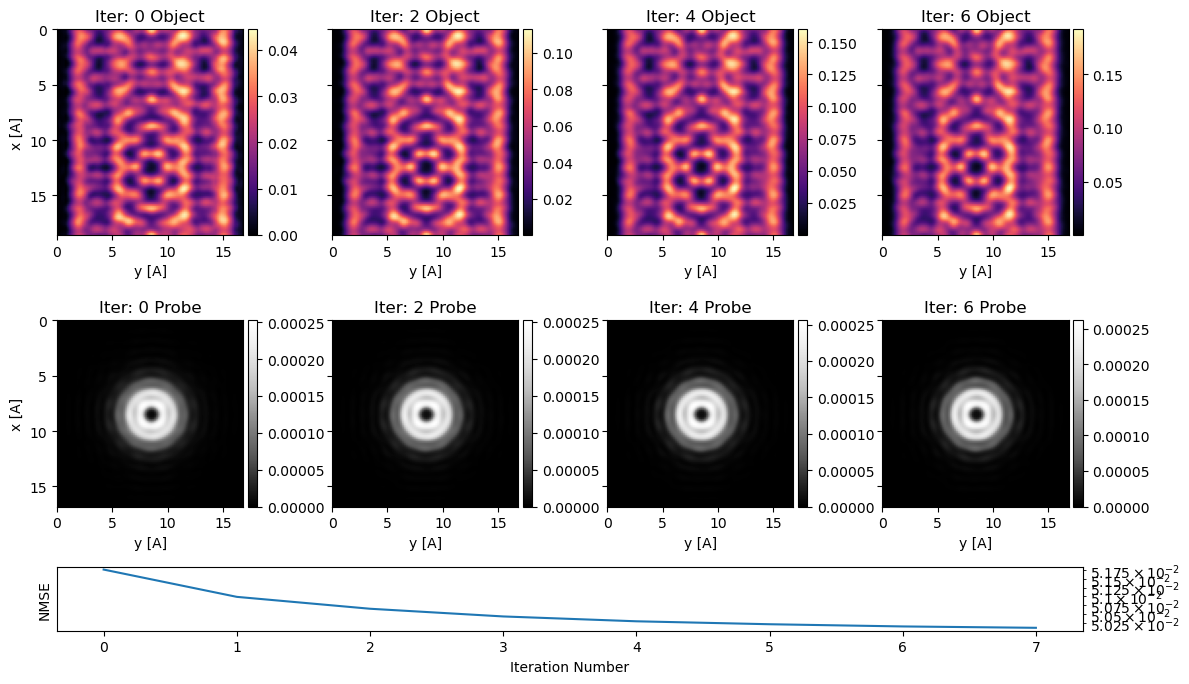

In [14]:
overlap_tomo = overlap_tomo.reconstruct(
    max_iter = 8,
    step_size=0.25,
    collective_tilt_updates=True,
    normalization_min=0.001,
    reset=True,
    store_iterations=True,
    q_lowpass=3.5,
).visualize(
    iterations_grid='auto',
    #projection_angle_deg=-90,
    #projection_axes=(0,1)
)

overlap_tomo_collective = overlap_tomo.object

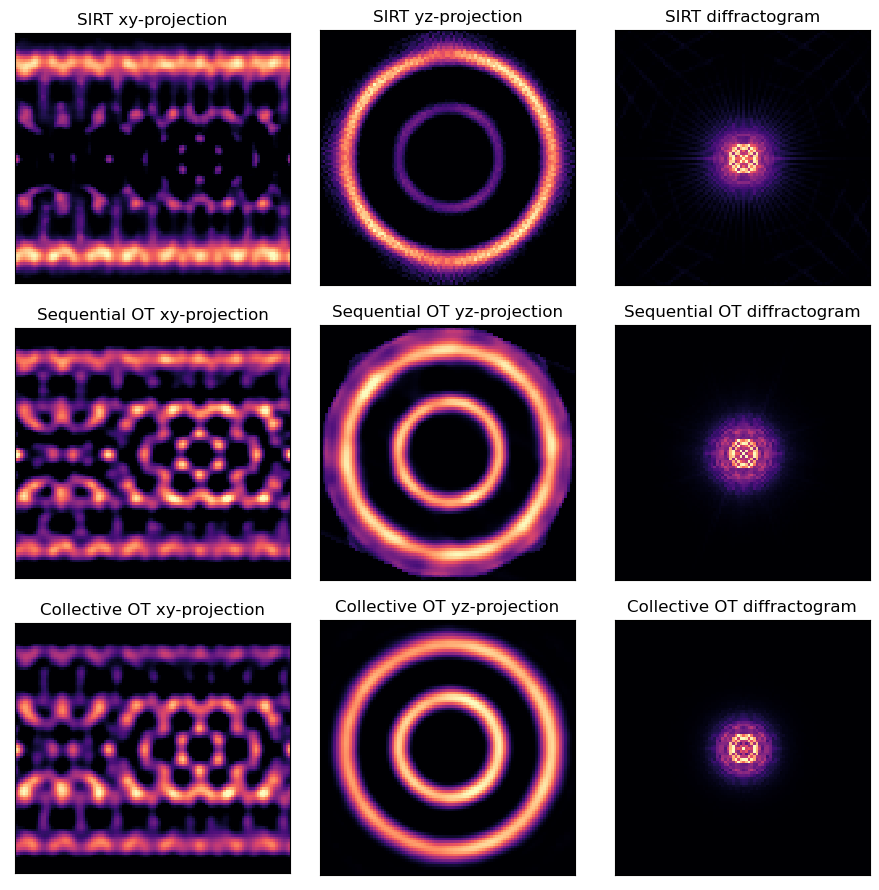

In [15]:
diffractogram_sequential = np.fft.fftshift(
        np.abs(np.fft.fftn(overlap_tomo_sequential))
    )

diffractogram_collective = np.fft.fftshift(
        np.abs(np.fft.fftn(overlap_tomo_collective))
    )

py4DSTEM.show(
    [
        [
            tomopy_recon.sum(1).T,
            tomopy_recon.sum(0),
            diffractogram_tomopy.sum(0),
        ],
        [
            overlap_tomo_sequential.sum(0).T,
            overlap_tomo_sequential.sum(1),
            diffractogram_sequential.sum(1),
        ],
        [
            overlap_tomo_collective.sum(0).T,
            overlap_tomo_collective.sum(1),
            diffractogram_collective.sum(1)
        ]
    ],
    vmin=0.333,
    vmax=0.999,
    cmap='magma',
    ticks=False,
    title=[
        "SIRT xy-projection", "SIRT yz-projection", "SIRT diffractogram",
        "Sequential OT xy-projection", "Sequential OT yz-projection", "Sequential OT diffractogram",
        "Collective OT xy-projection", "Collective OT yz-projection", "Collective OT diffractogram"
    ],
    axsize=(3,3),
)

## Missing Wedge

Experimentally, it is often challenging to acquire full-tilt series and conventional reconstructions often suffer from "missing-wedge" artifacts. Let's see how well overlap tomography does with a 60 degree missing wedge:

Preprocessing data: 100%|███████████████████████████████████████████████| 21/21 [00:16<00:00,  1.30tilt/s]


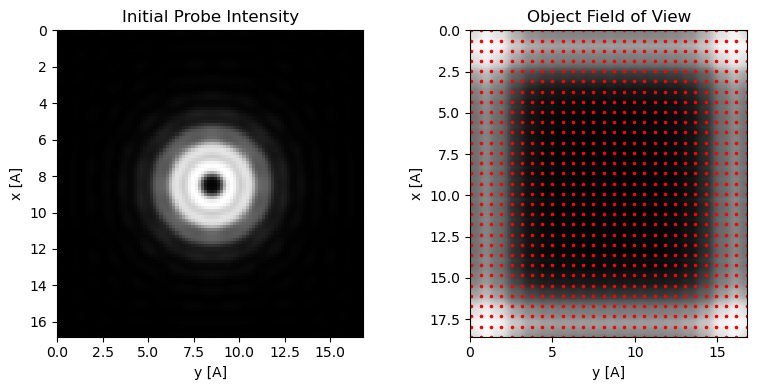

In [16]:
overlap_tomo = py4DSTEM.process.phase.OverlapTomographicReconstruction(
    dcs[5:-4],
    verbose=True,
    energy=80e3,
    num_slices=24,
    tilt_angles_degrees = np.linspace(-90,90,31)[5:-5],
    semiangle_cutoff=25,
    defocus=150,
    device='gpu',
    object_padding_px=(0,0),
).preprocess(
    plot_probe_overlaps=True,
    diffraction_patterns_rotate_degrees=0,
    diffraction_patterns_transpose=False
)

Performing 8 iterations using the gradient-descent algorithm, with normalization_min: 0.001.


Reconstructing object and probe: 100%|███████████████████████████████████| 8/8 [01:56<00:00, 14.62s/ iter]


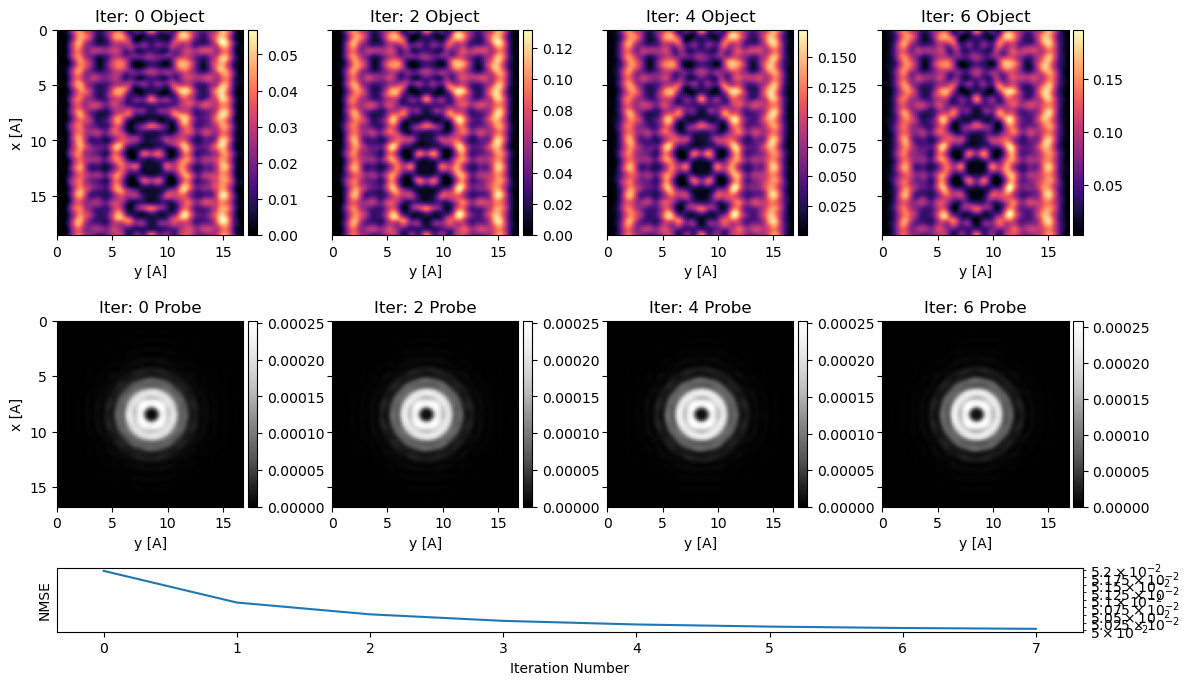

In [17]:
overlap_tomo = overlap_tomo.reconstruct(
    max_iter = 8,
    step_size=0.25,
    collective_tilt_updates=True,
    normalization_min=0.001,
    reset=True,
    store_iterations=True,
    q_lowpass=3.5,
).visualize(
    iterations_grid='auto',
    #projection_angle_deg=-90,
    #projection_axes=(0,1)
)

overlap_tomo_missing = overlap_tomo.object

We can compare the reconstruction with a missing wedge SIRT reconstruction:

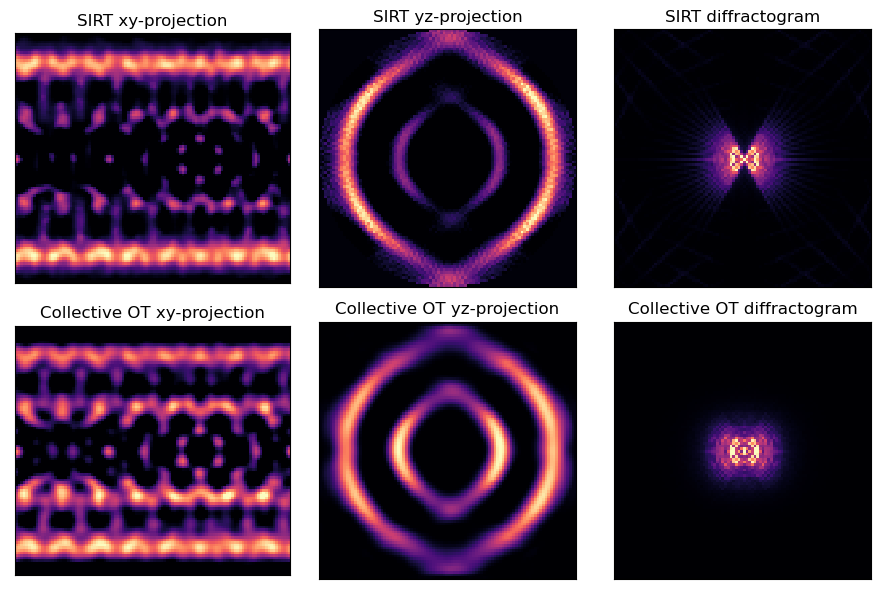

In [18]:
tomopy_recon_missing = tomopy.recon(ptycho_sinogram[5:-4].clip(0), angles_rad[5:-4], algorithm='sirt',num_iter=10)
tomopy_recon_missing = tomopy.circ_mask(tomopy_recon_missing, axis=0)

diffractogram_tomopy_missing = np.fft.fftshift(
        np.abs(np.fft.fftn(tomopy_recon_missing))
    )

diffractogram_collective_missing = np.fft.fftshift(
        np.abs(np.fft.fftn(overlap_tomo_missing))
    )

py4DSTEM.show(
    [
        [
            tomopy_recon_missing.sum(1).T,
            tomopy_recon_missing.sum(0),
            diffractogram_tomopy_missing.sum(0),
            
        ],
        [
            overlap_tomo_missing.sum(0).T,
            overlap_tomo_missing.sum(1),
            diffractogram_collective_missing.sum(1)
        ],
    ],
    vmin=0.333,
    vmax=0.999,
    cmap='magma',
    ticks=False,
    title=[
        "SIRT xy-projection", "SIRT yz-projection", "SIRT diffractogram",
        "Collective OT xy-projection", "Collective OT yz-projection", "Collective OT diffractogram"
    ],
    axsize=(3,3),
)

Indeed, we see that while SIRT cannot recover much information beyond the missing wedge, the overlap-tomography algorithm partly recovers that information!